In [1]:
# Import necessary libraries
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

In [2]:


# Load pre-trained ResNet50 model
# This model is trained on ImageNet and can be used for feature extraction
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()  # Set the model to evaluation mode

# Global variable to store activations from the target layer
activations = None

# Hook function to capture activations from the target layer
def forward_hook(module, input, output):
    global activations
    activations = output  # Save the output feature maps

# Register hook on the last convolutional layer of ResNet50
target_layer = model.layer4[2].conv3  # This is the last convolutional layer
target_layer.register_forward_hook(forward_hook)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.9MB/s]


In [5]:
# Function to preprocess the input image
def preprocess_image(img_path):
    """
    Loads and preprocesses the image:
    - Resizes it to 224x224 (required for ResNet50)
    - Converts it to a PyTorch tensor
    - Normalizes using ImageNet mean and standard deviation
    """
    img = Image.open(img_path).convert('RGB')  # Ensure it's in RGB format
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize image to fit ResNet50 input size
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per ImageNet
    ])
    return transform(img).unsqueeze(0)  # Add batch dimension

# Function to compute the Class Activation Map (CAM)
def compute_cam(img_path):
    """
    - Passes the image through the model.
    - Extracts the activation map from the last convolutional layer.
    - Uses the predicted class to generate a heatmap.
    """
    img = preprocess_image(img_path)
    output = model(img)  # Forward pass

    # Get the predicted class (highest score)
    class_idx = torch.argmax(output).item()

    # Extract activation map for the predicted class
    class_activation = activations[0, class_idx].detach().numpy()

    # Apply ReLU (only keep positive values)
    heatmap = np.maximum(class_activation, 0)

    # Normalize the heatmap (scale values between 0 and 1)
    heatmap /= np.max(heatmap)

    return heatmap, class_idx  # Return heatmap and predicted class index

# Function to overlay the heatmap on the original image
def overlay_heatmap(img_path, heatmap):
    """
    - Resizes the heatmap to match the original image size.
    - Applies a color map to highlight important regions.
    - Blends the heatmap with the original image.
    """
    img = cv2.imread(img_path)  # Read the original image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 8-bit (0-255)
    heatmap = np.uint8(255 * heatmap)

    # Apply color map for better visualization
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Blend original image and heatmap
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return img, heatmap, overlay

# Function to display results using Matplotlib
def display_results(img_path, heatmap, overlay, class_idx):
    """
    - Displays the original image, activation heatmap, and CAM overlay.
    - Uses Matplotlib for visualization.
    """
    # Load original image
    original = Image.open(img_path).convert('RGB')

    # Create a subplot with 3 images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(heatmap, cmap="jet")
    axes[1].set_title(f"Activation Map (Class {class_idx})")
    axes[1].axis("off")

    axes[2].imshow(overlay)
    axes[2].set_title("CAM Overlay")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

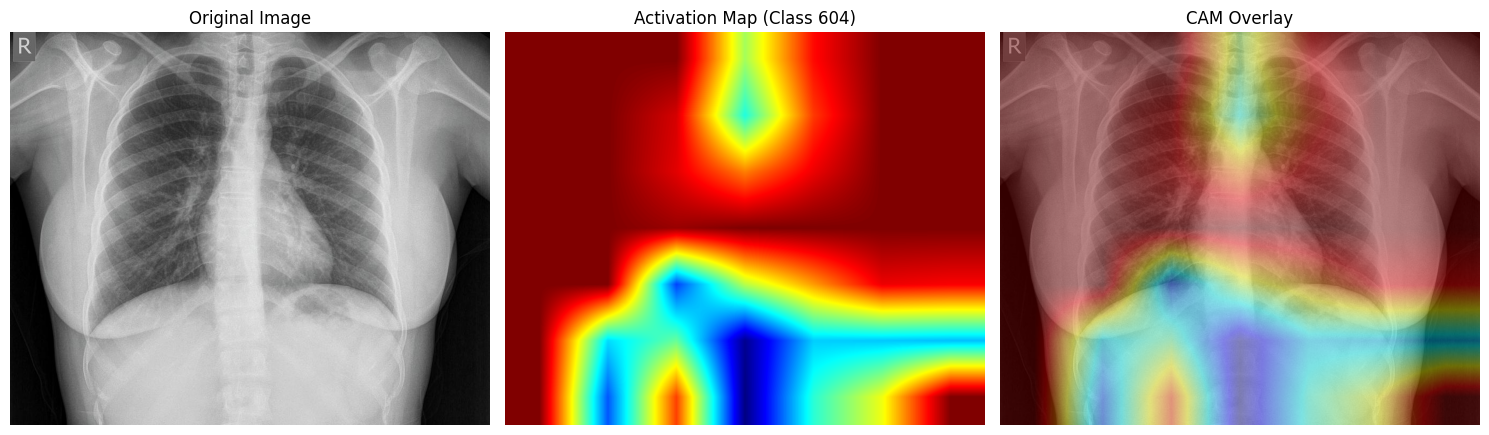

In [7]:
# Load a medical image for demonstration (e.g., chest X-ray)
img_path = "3-normal-healthy-chest-x-ray-photostock-israel.jpg"  # Replace with actual medical image path

# Generate CAM heatmap and overlay
heatmap, class_idx = compute_cam(img_path)
original_img, heatmap_img, overlay_img = overlay_heatmap(img_path, heatmap)

# Display the results
display_results(img_path, heatmap_img, overlay_img, class_idx)
